# **Introduction to this lab:**
In this lab, we will be doing a classification of the Quran Reciters. The dataset being used is an opensource dataset from Kaggle. You can read more about the data [here](https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification/). In this lab we will be doing audio classification. Feel free to change the dataset and try other datasets.



# 1. Initializations and Dataset Download
Lets start by downloading the dataset and installing the necessary library for downloading directly with the link from kaggle.

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omaratef3221
Your Kaggle Key: ··········


100%|██████████| 2.12G/2.12G [00:25<00:00, 88.3MB/s]


# 2. Imports
Then we will write all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use `cuda`. In case you want to train on Mac Silicon replace cuda with `mps`.

In [2]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import librosa # Library that is used to read and process audio files
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import time # Used to calculate time for each epoch or any processing time in seconds
from skimage.transform import resize # Used to resize the images and we will use it to resize audio waves

# detect the GPU if any, if not use CPU, change "cuda" to "mps" if you have a mac
device = "cuda" if torch.cuda.is_available() else "cpu"

# 3. Data
The dataframe comes with a csv file that contains the path of each audio file and its corresponding label (Quran Reciter). We will read this dataframe.

Then we will modify the path and add the full path to it so that it allows us to read the audio file with respect to colab structure. Then we visualize the first 5 rows of the dataframe.

Keep in mind that this step is not the same for every dataset, you may need to read the dataset differently depends on its structure.


In [24]:
data_df = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv") # Read the original csv as a dataframe

data_df['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset/' + data_df['FilePath'].str[1:] # Modify the paths in the dataframe


data_df.head() # Visualize the first 5 rows

,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
1,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
2,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
3,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
4,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan


# 4. Data investigation
Now lets dig deeper into our dataset. In the cell below we print the shape of the data which is represented by (rows, columns), then we plot the data distribution for each class. we can see below that our dataset is not 100% balanced but its almost balanced.

Data Shape is:  (6687, 2)


Claases Distrubution is: 


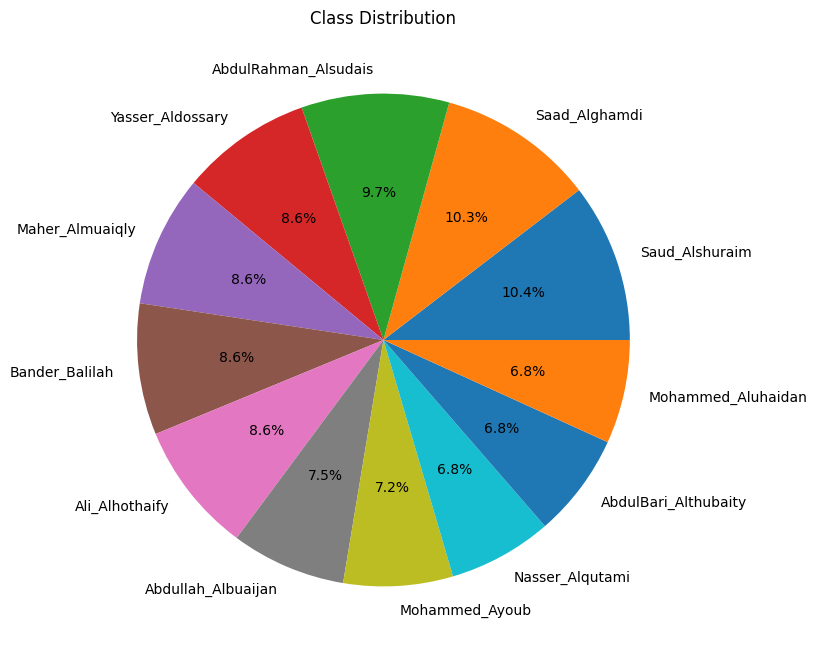

In [26]:
print("Data Shape is: ", data_df.shape) # Print the data shape (rows, columns)
print() # Empty line for better viewing

print() # Empty line for better viewing
print("Claases Distrubution is: ")

class_counts = data_df['Class'].value_counts() # Get how many data sample for each class
plt.figure(figsize=(8, 8)) # Plot a figure of 8 by 8 pixels

# we use this for plotting the how many data sample for each class
# autopct='%1.1f%%' automatically adds a label to each slice of the pie with its percentage of the whole, formatted to one decimal place.
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')


plt.title('Class Distribution') # Add title to the whole figure

plt.show() # Visualize/show the figure - Like print()


# 5. Data Split
Now lets split the dataset into training, validation and testing. Here we will be using it in a bit different way since we will be reading the image paths from the dataframe so better we split the dataframe directly and then read the images. We will do that by getting a random sample of 70% from our data using data_df.sample(frac=0.7,random_state=7) then we will create a new variable of test dataset which we will drop from it the 70% of the train which means that it will be 30% of the data which is the rest of the data using data_df.drop(train.index). Then we will do the same between testing to create validation which will be 50% of the data which means the final split we have is the following:

* Training: 70%
* Validation: 15%
* Testing: 15%

In [27]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%


print("Training Shape: ", train.shape) # Print the Trainnig shape (rows, columns)
print("Validation Shape: ", val.shape) # Print the Validation shape (rows, columns)
print("Testing Shape: ", test.shape) # Print the Testing shape (rows, columns)

Training Shape:  (4681, 2)
Validation Shape:  (1003, 2)
Testing Shape:  (1003, 2)


# 6. Custom Dataset Class

Now lets create some preprocessing objects, first we start by LabelEncoder which converts string classes to numeric for example instead of having the classes as (x, y) it will be (0,1) because machines understands numbers only.

Then we will have our custom dataset class that inherits from `Dataset` class in PyTorch. PyTorch objects are much efficient and easily customizable.

In [8]:
label_encoder = LabelEncoder() # Encode the string classes to numeric

class CustomAudioDataset(Dataset):
  def __init__(self, dataframe, target_length = 16000):
    self.dataframe = dataframe
    self.target_length = target_length
    self.labels = torch.Tensor(label_encoder.fit_transform(dataframe['Class'])).type(torch.LongTensor).to(device)
    self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = torch.Tensor(self.labels[idx]).to(device)
    audio = (self.audios[idx]).unsqueeze(0).to(device)
    return audio, label

  def read_audio_file(self, audio_file):
    audio, _ = librosa.load(audio_file, sr=None)

    if len(audio) < self.target_length:
      audio = np.pad(audio, (0, self.target_length - len(audio))) # Pad the audio if it's shorter than the target length
    elif len(audio) > self.target_length:
      start = np.random.randint(0, len(audio) - self.target_length) # Crop the audio if it's longer than the target length
      audio = audio[start:start + self.target_length]
    return audio

  def get_spectrogram(self, file_path):
    # Set the sample rate and duration of the audio files
    sr = 22050
    duration = 5

    # Set the size of the spectrogram images
    img_height = 128
    img_width = 256
    # Load the audio file
    signal, sr = librosa.load(file_path, sr=22050, duration=duration)
    # Compute the spectrogram
    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    # Convert the spectrogram to dB scale
    spec_db = librosa.power_to_db(spec, ref=np.max)
    # Resize the spectrogram to the desired shape
    spec_resized = librosa.util.fix_length(spec_db, size = duration * sr // 512 + 1)
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
    return spec_resized

In [9]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

In [10]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [11]:
print(train_dataset.__getitem__(3)[0].shape)
print(val_dataset.__getitem__(3)[0].shape)
print(test_dataset.__getitem__(3)[0].shape)

torch.Size([1, 128, 256])
torch.Size([1, 128, 256])
torch.Size([1, 128, 256])


In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1) # First Convolution layer
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1) # Second Convolution layer
    self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1) # Third Convolution layer
    self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
    self.relu = nn.ReLU() # ReLU Activation function

    self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
    self.linear1 = nn.Linear((32768), 4096) # Traditional Dense (Linear)
    self.linear2 = nn.Linear(4096, 1024) # Traditional Dense (Linear)
    self.linear4 = nn.Linear(1024, 512) # Traditional Dense (Linear)
    self.output = nn.Linear(512, len(data_df['Class'].unique())) # Output Linear Layer

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv1(x) # -> Outputs: (16, 16000)
    x = self.pooling(x)# -> Outputs: (16, 8000)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv2(x) # -> Outputs: (32, 8000)
    x = self.pooling(x) # -> Outputs: (32, 4000)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv3(x) # -> Outputs: (64, 4000)
    x = self.pooling(x) # -> Outputs: (64, 2000)
    x = self.relu(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)

    x = self.flatten(x)

    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)


    x = self.linear4(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device


print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [14]:
from torchsummary import summary # Visualize the model layers and number of parameters
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
           Dropout-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
         MaxPool2d-6           [-1, 32, 32, 64]               0
              ReLU-7           [-1, 32, 32, 64]               0
           Dropout-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
        MaxPool2d-10           [-1, 64, 16, 32]               0
             ReLU-11           [-1, 64, 16, 32]               0
          Dropout-12           [-1, 64, 16, 32]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

In [21]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  start_time = time.time()
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)} Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)} -- Time/Epoch: {str(round(time.time()-start_time, 2))} Seconds.''')
  print()

Epoch 1/25, Train Loss: 7.1379 Train Accuracy 12.6896 Validation Loss: 1.5278 Validation Accuracy: 13.4596 -- Time/Epoch: 18.11 Seconds.

Epoch 2/25, Train Loss: 7.0117 Train Accuracy 14.7618 Validation Loss: 1.4756 Validation Accuracy: 17.7468 -- Time/Epoch: 18.87 Seconds.

Epoch 3/25, Train Loss: 6.5467 Train Accuracy 21.9398 Validation Loss: 1.312 Validation Accuracy: 27.4177 -- Time/Epoch: 18.54 Seconds.

Epoch 4/25, Train Loss: 5.8172 Train Accuracy 31.4676 Validation Loss: 1.1705 Validation Accuracy: 37.7866 -- Time/Epoch: 18.01 Seconds.

Epoch 5/25, Train Loss: 5.2601 Train Accuracy 37.5134 Validation Loss: 1.0462 Validation Accuracy: 41.4756 -- Time/Epoch: 17.82 Seconds.

Epoch 6/25, Train Loss: 4.8289 Train Accuracy 43.1532 Validation Loss: 0.9852 Validation Accuracy: 45.8624 -- Time/Epoch: 17.82 Seconds.

Epoch 7/25, Train Loss: 4.4039 Train Accuracy 48.2803 Validation Loss: 0.957 Validation Accuracy: 49.5513 -- Time/Epoch: 17.75 Seconds.

Epoch 8/25, Train Loss: 4.0738 Train

In [22]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 88.24%


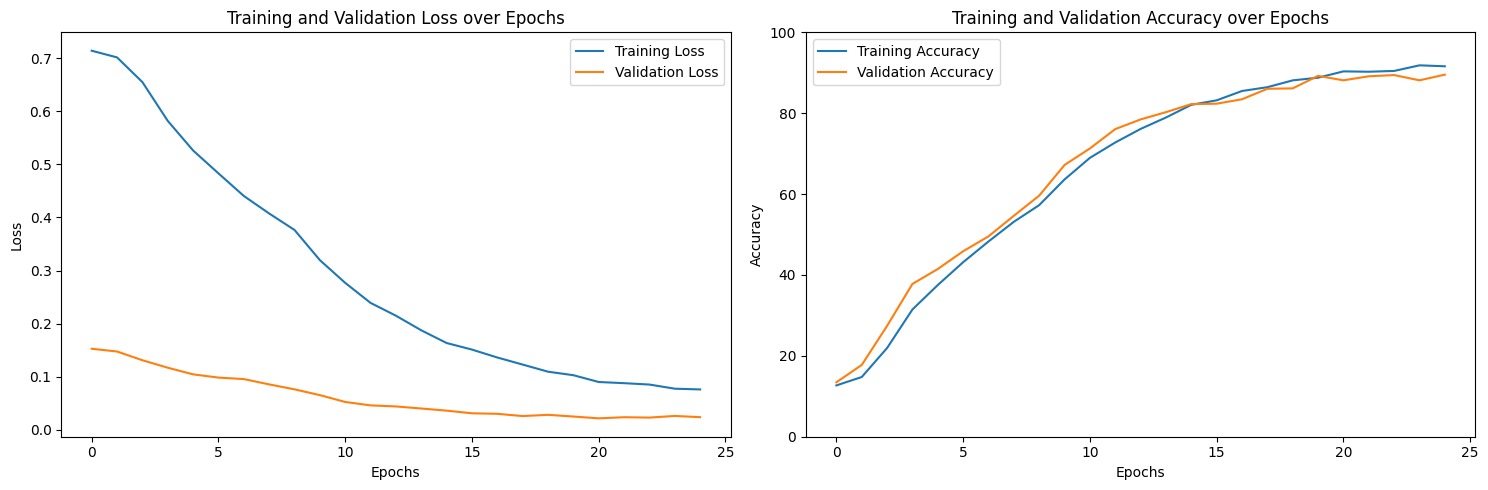

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()